# Homework 5: Inference and Machine Learning

Luca Grandinetti, Iacopo Poli, Davide Romanin, Gennaro Tucci

In [1]:
import numpy as np
from numpy.random import random as rnd
import matplotlib.pyplot as plt
%matplotlib inline

## Statistical inference and MSE

A system emits particle with a half-length decay, which is detected if $1< x <20$. The probability to observe such a decay is:

\begin{equation}
P_{\lambda}(x) = \begin{cases}
\frac{\exp(-\frac{x}{\lambda})}{Z(\lambda)} & \mbox{ if } 1< x < 20\\
0 & \mbox{otherwise}
\end{cases}
\end{equation}

### Probability distribution and data generation

Compute the normalization:

$$
Z(\lambda) = \int_{1}^{20} \exp(-\frac{x}{\lambda}) dx = \lambda \left ( e^{-1/\lambda} - e^{-20/\lambda} \right )
$$

The probability for a set of $N$ events $\left \{ x \right \} = \left \{ x_1, \ldots, x_N \right \}$:

$$
P_{\lambda}(\left \{ x \right \}) = \frac{\exp(-\frac{\sum_{i=1}^{N} x_i}{\lambda})}{Z^N(\lambda)}
$$

In [63]:
def generate_samples(n, d):
    # d = lambda
    # n = number of samples
    def sample(d):
        return 1-d*np.log(1+(np.exp(-19./d)-1)*rnd())
    
    samples = []
    
    for i in xrange(n):
        samples.append(sample(d))
    
    return samples

In [64]:
n_samples = 5000
d = 5

data = generate_samples(n_samples, d)

(array([ 0.17224662,  0.11627174,  0.08022012,  0.05555322,  0.03436499,
         0.02487772,  0.01897454,  0.01117389,  0.0067465 ,  0.00664109]),
 array([  1.0010032 ,   2.89828284,   4.79556249,   6.69284214,
          8.59012178,  10.48740143,  12.38468107,  14.28196072,
         16.17924037,  18.07652001,  19.97379966]),
 <a list of 10 Patch objects>)

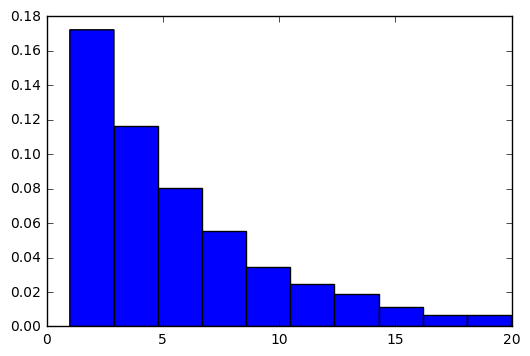

In [65]:
plt.hist(data, normed=True)

### Maximum likelihood

In [66]:
def zeta(d):
    return d*(np.exp(-1./d)-np.exp(-20./d))

def loglikelihood(n, x_sum, d):
    return -x_sum/d-n*np.log(zeta(d))
# np.exp(-np.sum(x)/d)/zeta(d)**n
# -np.sum(x)/d-n*np.log(zeta(d))

def gradient(n, x_sum, d):
    #def zeta_first(d):
    #    return np.exp(-1./d)*(1+1./d)-np.exp(-20./d)*(1+20./d)
    
    return x_sum/d**2 - n/zeta(d)*(np.exp(-1./d)*(1+1./d)-np.exp(-20./d)*(1+20./d))
# likelihood(n, x, d)*(np.sum(x)/d**2-n*zeta_first(d)/zeta(d))
# np.sum(x)/d**2 - n/zeta(d)*(np.exp(-1./d)*(1+1./d)-np.exp(-20./d)*(1+20./d))

def constrained_gradient_ascent(data_sum, n, eta, eps, d0, maxiter):
    LL0 = 0
    grad = float("inf")
    i=0
    while(np.abs(grad) > eps and i < maxiter):
        LL = loglikelihood(n, data_sum, d0)
        grad = gradient(n, data_sum, d0)
        d0 += eta*grad
        while(d0 < 0):
            d0-=eta*grad/2
        i+=1
    return d0

In [67]:
def MSE(data_sum, data_len, d):
    # NAIVE SEARCH to initialize projected gradient ascent
    # with the assumption lambda in [0.05, 100]
    # gradient ascent finds the max even if this assumption
    # is wrong and it is outside of this interval.
    lambda_vector = np.linspace(0.05, 100, 100000)
    LL = loglikelihood(data_len, data_sum, lambda_vector)
    d_estimate = lambda_vector[np.argmax(LL)]
    # GRADIENT ASCENT
    #d_estimate = constrained_gradient_ascent(data_sum, data_len, 1e-3*d_estimate, 1e-6, d_estimate, 20000)
    # ERROR ESTIMATE
    squared_error = (d_estimate-d)**2
    return d_estimate, squared_error

In [68]:
real_d = [0.5, 1, 5, 10, 15, 20, 30]
n_samples = 1000
n_iter = 100
SE_ML = np.zeros((3, len(real_d)))
temp1 = []
temp2 = []

for j in xrange(0, n_iter):
    for d in real_d:
        data = generate_samples(n_samples, d)
        for i in [10, 100, 1000]:
            d_estimate, squared_error = MSE(np.sum(data[0:i]), i, d)
            temp1.append(squared_error)
        
        temp2.append(temp1)
        temp1 = []

    SE_ML += np.asarray(zip(*temp2))
    temp2=[]
    
SE_ML/=n_iter

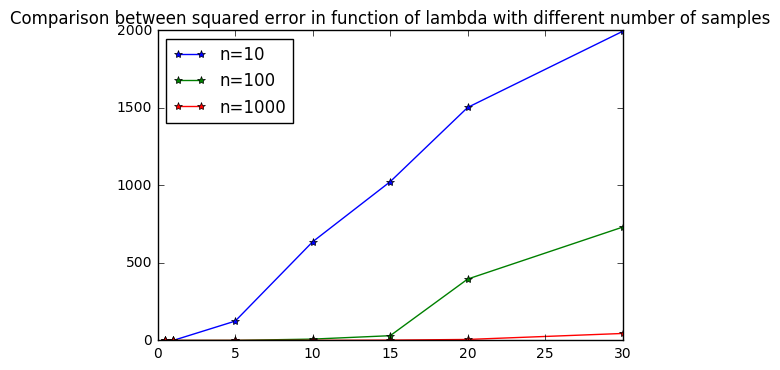

In [69]:
plt.plot(real_d, SE_ML[0], "*-", label="n=10")
plt.plot(real_d, SE_ML[1], "*-", label="n=100")
plt.plot(real_d, SE_ML[2], "*-", label="n=1000")
plt.legend(loc="best")
plt.title("Comparison between squared error in function of lambda with different number of samples")

### Comparison with Cramer-Rao bound

In [70]:
real_d = [0.5, 1, 5, 10, 15, 20, 30]
n_samples = 10000
n_iter = 100
mean_squared_error = []
std_squared_error = []
temp = []
factor = n_iter**(-0.5)

for d in real_d:
    for j in xrange(0, n_iter):
        data = generate_samples(n_samples, d)
        d_estimate, squared_error = MSE(np.sum(data), n_samples, d)
        temp.append(squared_error)
        
    mean_squared_error.append(np.mean(temp))
    std_squared_error.append(np.std(temp)*factor)
    temp = []

print mean_squared_error, "\n"
print std_squared_error, "\n"

[2.6568170468252609e-05, 0.00011968669028683669, 0.0040499064402863098, 0.035875138067243822, 0.18053571825207637, 0.46352469325363788, 3.6433337996533846] 

[3.3419190259650789e-06, 1.9856383038103173e-05, 0.00057603922567322629, 0.006052243641272128, 0.02235766078520815, 0.067013891076260976, 0.51805613469230527] 



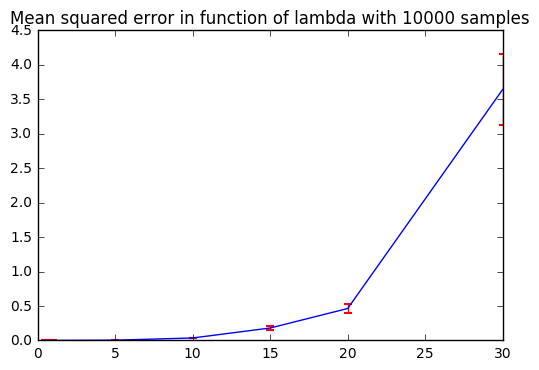

In [71]:
plt.errorbar(real_d, mean_squared_error, yerr=std_squared_error, ecolor="r", capthick=1.5)
plt.title("Mean squared error in function of lambda with 10000 samples")

In [72]:
def fisher_info(d, n):
    # thanks Wolfram Alpha
    return n*(d**2-(361*np.exp(19./d))/(-1+np.exp(19./d))**2)/d**4

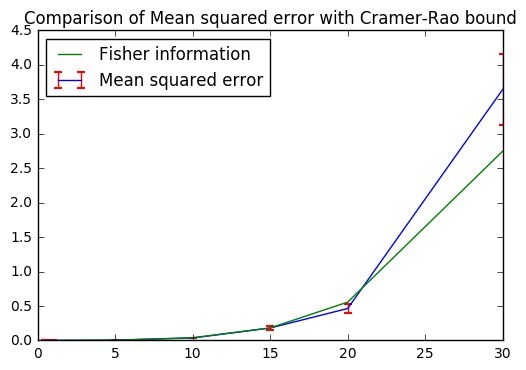

In [73]:
plt.errorbar(real_d, mean_squared_error, yerr=std_squared_error, ecolor="r", capthick=1.5, label="Mean squared error")
plt.plot(real_d, fisher_info(np.asarray(real_d), n_samples)**(-1), label="Fisher information")
plt.legend(loc="best")
plt.title("Comparison of Mean squared error with Cramer-Rao bound")

In [1]:
# TODO: IS THIS ESTIMATOR UNBIASED?

### Maximum a posteriori estimation

Adopting a Bayesian point of view and following Jeffreys, we use the prior $P(\lambda) \propto \sqrt{I(\lambda)}$. The posterior, for a single event, now is:

\begin{equation}
P(\lambda \rvert x_i) = \begin{cases}
\frac{\exp(-x_i/\lambda + \frac{1}{2}\log I(\lambda))}{Z(\lambda)} & \mbox{ if } 1< x < 20\\
0 & \mbox{otherwise}
\end{cases}
\end{equation}

The MAP estimator with this prior is:

$$
\lambda_{MAP}(\left \{ x \right \}) = \mbox{argmax}_{\lambda} P(\lambda \rvert \left \{ x \right \})
$$

In [2]:
# TODO: IS THIS ESTIMATOR UNBIASED?

In [74]:
def MAP(n, data_sum, d):
    return -data_sum/d+n*(np.log(fisher_info(d, n))/2-np.log(zeta(d)))

In [75]:
def MAPMSE(data_sum, data_len, d):
    # NAIVE SEARCH to initialize projected gradient ascent
    # with the assumption lambda in [0.05, 100]
    # gradient ascent finds the max even if this assumption
    # is wrong and it is outside of this interval.
    lambda_vector = np.linspace(0.05, 100, 100000)
    maxap = MAP(data_len, data_sum, lambda_vector)
    d_estimate = lambda_vector[np.argmax(maxap)]
    # GRADIENT ASCENT
    #d_estimate = constrained_gradient_ascent(data_sum, data_len, 1e-3*d_estimate, 1e-6, d_estimate, 20000)
    # ERROR ESTIMATE
    squared_error = (d_estimate-d)**2
    return d_estimate, squared_error

In [76]:
real_d = [0.5, 1, 5, 10, 15, 20, 30]
n_samples = 10000
n_iter = 100
MAPmean_squared_error = []
MAPstd_squared_error = []
temp = []
factor = n_iter**(-0.5)

for d in real_d:
    for j in xrange(0, n_iter):
        data = generate_samples(n_samples, d)
        d_estimate, squared_error = MAPMSE(np.sum(data), n_samples, d)
        temp.append(squared_error)
        
    MAPmean_squared_error.append(np.mean(temp))
    MAPstd_squared_error.append(np.std(temp)*factor)
    temp = []
    
print MAPmean_squared_error, "\n"
print MAPstd_squared_error, "\n"

/Users/giacomopoli/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in square
  app.launch_new_instance()


[0.062382149312455545, 0.24986916148753785, 7.6676611545276669, 47.979504667609106, 134.52068325453965, 269.99638179293822, 689.49337967125643] 

[0.00014133804299808509, 0.00053417571096886789, 0.0096720195530052965, 0.02406340617071618, 0.052428947878729149, 0.064505250767104769, 0.093697387151904898] 



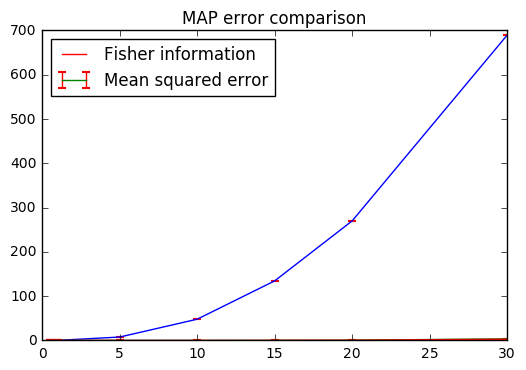

In [77]:
plt.errorbar(real_d, MAPmean_squared_error, yerr=MAPstd_squared_error, ecolor="r", capthick=1.5)
plt.errorbar(real_d, mean_squared_error, yerr=std_squared_error, ecolor="r", capthick=1.5, label="Mean squared error")
plt.plot(real_d, fisher_info(np.asarray(real_d), n_samples)**(-1), label="Fisher information")
plt.legend(loc="best")
plt.title("MAP error comparison")

#SOMETHING WENT TERRIBLY WRONG HERE

## The MNIST dataset

In [ ]:
# SHOW BEST VALUE OF THETA: COPIARE CONTI DI GENNARO
# TODO: WHY CAN M BE INTERPRETED AS THE NUMBER OF NEURONS IN HIDDEN LAYER?

In [34]:
import mnist as mn
import matplotlib as mpl
from copy import deepcopy
from scipy.special import expit #sigmoid function

In [22]:
def load_MNIST():
    MNIST_data = mn.MNIST("./mnist")
    MNIST_data.load_training();
    MNIST_data.load_testing();
    return np.asarray(MNIST_data.train_images), np.asarray(MNIST_data.test_images), \
           np.asarray(MNIST_data.train_labels), np.asarray(MNIST_data.test_labels)

In [23]:
def display_digit(element_of_x):
    img = np.reshape(element_of_x,(28,28))
    imgplot = plt.imshow(img, cmap = mpl.cm.Greys)

In [24]:
x_train, x_test, y_train, y_test = load_MNIST()

In [35]:
def data_preprocessing(labels, digit):
    y = deepcopy(labels)
    y[np.where(labels == digit)] = 1
    y[np.where(labels != digit)] = -1
    return y

In [52]:
class NeuralNet(object):
    def __init__(self , f, m):
        self.m = m
        self.f = f
        self.theta = np.asarray([np.zeros(m) for i in xrange(10)])
        self.R = np.random.randn( 784, m)
    
    def evaluation(self, x):
        output_digit = 0
        max_output = 0
        for i in xrange(10):
            out = np.dot(self.theta[i], self.f(np.dot(x, self.R)))
            is_max = out > max_output or i == 0
            
            if is_max:
                output_digit = i
                max_output = out
        
        return output_digit
    
    def learning(self, gamma, x, y):
        print "Compute F..."
        F = self.f(np.dot(x, self.R)) # 60000 x 784 x 784 x m = 60000 x m
        print "And its transpose..."
        FT = zip(*F) # m x 60000
        print "Inverting a big matrix..."
        inverse = np.linalg.inv(np.dot(FT, F) + gamma*np.eye(self.m)) # m x m
        for i in xrange(10):
            print "Comput output for ", i
            processed_y = data_preprocessing(y,i)
            self.theta[i] = np.dot(inverse, np.dot(FT, processed_y)) # m x m x (m x 60000 x 60000) = m
        print "Trained successfully"
        
        
    def testing_error(self, x_test, y_test):
        error = 0
        for i in xrange(len(y_test)):
            if self.evaluation(x_test[i]) != y_test[i]:
                error += 1.0
        return error/len(y_test)

In [ ]:
# TODO: DO THIS FOR DIFFERENT VALUES OF M

In [53]:
classifier = NeuralNet(expit, 1000)

In [54]:
classifier.learning(1e-2, x_train, y_train)

Compute F...
And its transpose...
Inverting a big matrix...
Comput output for  0
Comput output for  1
Comput output for  2
Comput output for  3
Comput output for  4
Comput output for  5
Comput output for  6
Comput output for  7
Comput output for  8
Comput output for  9
Trained successfully


In [55]:
classifier.testing_error(x_test, y_test)

0.0817

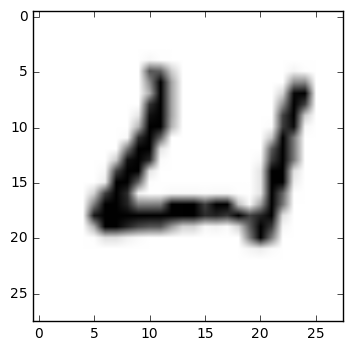

Net output:  0  Actual output:  4


In [62]:
for i in xrange(len(y_test)):
    if classifier.evaluation(x_test[i])!=y_test[i]:
                
        test=np.reshape(x_test[i],(28,28))
        
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        imgplot = ax.imshow(test, cmap=mpl.cm.Greys)
        plt.show()
        print "Net output: ", classifier.evaluation(x_test[i]), " Actual output: ", y_test[i]
        break